After submitting admissions the students were awarded with some amount of money, depending on the `Univeraity Rating` and `Chance of Admit`.

$$ \textrm{Award} = \textrm{Chance of Admit} * \textrm{multiplier}_{\textrm{University Rating}}$$

However some information has been lost:
- `Chance of Admit` for each student
- Multipliers

Fortunatelly we have information about the award amounts (`Award`) and students data (`GRE Score`, `TOEFL Score`, `University Rating`, `SOP`, `LOR`, `CGPA`, `Research`, `Chance of Admit`) from admissions.

Build a Bayesian model (possibly linear) for predicting `Chance of Admit` and use in a model that predicts `Award` and train them simultanously using `x_train` and `y_train_award`.

Evaluate the obtained models on:
- `x_test` and `y_test_award` with the stacked model
- `x_test` and `y_test_chance` with the "internal" model

In [3]:
%load_ext autoreload
%autoreload 2

import pickle
import pyro
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
import pyro.distributions as dist
from torch import nn
import torch
from torch.distributions import constraints
from pyro.optim import SGD, Adam
from matplotlib import pyplot as plt


Bad key "text.kerning_factor" on line 4 in
C:\Users\Wilk-PC\Anaconda3\envs\lab\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
import sys
sys.path.append('./')

In [5]:
from src.utils import run_svi, SviPredictive, summary
from src.visualization import plot_predictions

In [6]:
with open('./data/stacked-regression.pkl', 'rb') as f:
    data = pickle.load(f)
x_train = data['x_train']
y_train_award = data['y_train_award']
y_train_chance = data['y_train_chance']
x_test = data['x_test']
y_test_award = data['y_test_award']
y_test_chance = data['y_test_chance']
print(data['x_train'][0])

tensor([1.1103, 0.6268, 4.0000, 1.1374, 0.5581, 0.7176, 1.0000])


In [29]:
class BayesianLinearRegression(PyroModule):
    def __init__(self, n_input):
        super().__init__()
        self.n_input = n_input
        
    def model(self, x, y=None):
        b_GRE = pyro.sample("b_GRE", dist.Normal(x[:,0], 1))
        b_TEOFL = pyro.sample("b_TEOFL", dist.Normal(x[:,1], 1))
        b_university = pyro.sample("b_university", dist.Normal(x[:,2], 1))
        b_SOP = pyro.sample("b_SOP", dist.Normal(x[:,3], 1))
        b_LOP = pyro.sample("b_LOP", dist.Normal(x[:,4], 1))
        b_CGPA = pyro.sample("b_CGPA", dist.Normal(x[:,5], 1))
        b_research = pyro.sample("b_research", dist.Normal(x[:,6], 1))

        sigma = pyro.sample("sigma", dist.Uniform(0.,10.))

        mean = (
                b_GRE * x[:, 0] +
                b_TEOFL * x[:, 1] +
                b_university * x[:, 2] +
                b_SOP * x[:, 3] +
                b_LOP * x[:, 4] +
                b_CGPA * x[:, 5] +
                b_research * x[:, 6]
        )
        with pyro.plate("data", x.shape[0]):
            sample = pyro.sample("chance_off_admit-obs", dist.Normal(mean, sigma), obs=y)
            return sample

    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)
    
    def guide(self, x, y=None):
        # Make sure that guide returns a value
        loc = pyro.param('loc', torch.randn(7))
        scale = pyro.param('scale', torch.ones(7),constraint=constraints.positive)
        b_GRE = pyro.sample("b_GRE", dist.Normal(loc[0], scale[0]))
        b_TEOFL = pyro.sample("b_TEOFL", dist.Normal(loc[1], scale[1]))
        b_university = pyro.sample("b_university", dist.Normal(loc[2], scale[2]))
        b_SOP = pyro.sample("b_SOP", dist.Normal(loc[3], scale[3]))
        b_LOP = pyro.sample("b_LOP", dist.Normal(loc[4], scale[4]))
        b_CGPA = pyro.sample("b_CGPA", dist.Normal(loc[5], scale[5]))
        b_research = pyro.sample("b_research", dist.Normal(loc[6], scale[6]))
        sigma = pyro.sample("sigma", dist.Uniform(0.,10.))
        mean = (
                b_GRE * x[:, 0] +
                b_TEOFL * x[:, 1] +
                b_university * x[:, 2] +
                b_SOP * x[:, 3] +
                b_LOP * x[:, 4] +
                b_CGPA * x[:, 5] +
                b_research * x[:, 6]
        )
        
        with pyro.plate("data", x.shape[0]):
            sample = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
            return sample

    
class StackedModel(nn.Module):
    
    def __init__(self, n_input, initial_multipliers, university_rating_column, university_ratings):
        super().__init__()
        pyro.clear_param_store()
        self.logit = nn.Sigmoid()
        self.linear_regression = BayesianLinearRegression(n_input)
        self.initial_multipliers = initial_multipliers
        self.university_rating_column = university_rating_column
        self.university_ratings = university_ratings
        #self.params_store = pyro.get_param_store()
        
    def model(self, x, y=None):
        chance_off_admit = self.logit(self.linear_regression.forward(x))
        size = len(self.initial_multipliers)
        multi = torch.Tensor(size)
        for key in self.university_ratings:
            multi[key-1]=self.initial_multipliers[key]
        multiplier_param = pyro.param('multiplier_model',multi)
        sigma = pyro.sample("Stacked_sigma", dist.Uniform(0.,10.))
        samples = []
        for i in pyro.plate("data_stacked",x.shape[0]):  
            key = int(x[i][self.university_rating_column])
            multiplier = multiplier_param[key-1]
            award = chance_off_admit[i] * multiplier
            samples.append(pyro.sample(f'award{i}',dist.Normal(award,sigma),obs=y))
        return torch.cat(samples)
    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)
    
    def guide(self, x, y=None):
        chance_off_admit = self.logit(self.linear_regression.guide(x))
        size = len(self.initial_multipliers)
        multi = torch.Tensor(size)
        sigma_param = pyro.param('Stacked_sigma_param',torch.rand(1),constraint=constraints.positive)
        sigma = pyro.sample("Stacked_sigma", dist.Delta(sigma_param))
         #initial values for param
        for key in self.university_ratings:
            multi[key-1]=pyro.sample(f"multiplier_{key}",dist.Normal(self.initial_multipliers[key],30))
        multiplier_param = pyro.param('multiplier_guide',multi)
        samples = []
        for i in pyro.plate("stacked-obs",x.shape[0]):
            key = int(x[i][self.university_rating_column])
            award = chance_off_admit[i] * multiplier_param[int(key-1)]
            samples.append(pyro.sample(f'award-stacked{i}',dist.Normal(award,sigma),obs=y))
        return torch.cat(samples)

In [32]:
m = StackedModel(
    n_input=7,
    initial_multipliers={
        1: 90,
        2: 54,
        3: 32,
        4: 101,
        5: 56,
    },
    university_rating_column=2,
    university_ratings=range(1,6),
)

elbos, params = run_svi(
    m,
    m.guide,
    x_train,
    y_train_award,
    verbose=True,
    optimizer=Adam({"lr": 0.0002}),
    num_iters=5_000,
    loss=TraceGraph_ELBO()
)
print(dict(pyro.get_param_store()))
plt.plot(elbos)
plt.title('ELBO')
plt.show()

for param in params[0].keys():
    y = [d[param].detach().reshape(-1).numpy() for d in params]
    plt.plot(y)
    plt.title(param)
    plt.show()

KeyboardInterrupt: 

# Model evaluation

In [34]:
num_samples = 1_000

## Chance of Admit Model Evaluation

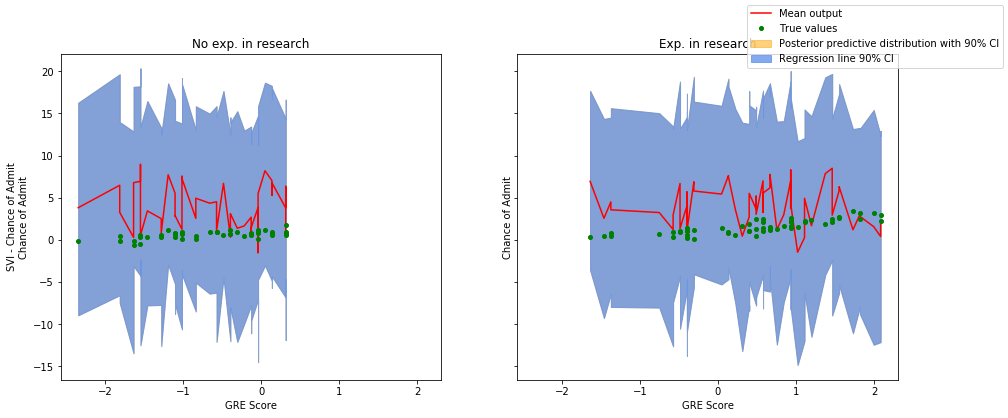

In [35]:
chance_predictive = SviPredictive(
    m.linear_regression.model,
    guide=m.linear_regression.guide,
    num_samples=num_samples,
    return_sites=('chance_off_admit-obs','_RETURN')
)
properties = {
    'x': 0,
    'x_label': "GRE Score",
    'y_label': "Chance of Admit",
    'category': 6,
    'category_labels': {
        0: "No exp. in research",
        1: "Exp. in research",
    }
}
predictors = {
    'SVI - Chance of Admit': chance_predictive
}
data = {
    'x': x_test,
    'y': torch.log(y_test_chance / (1 - y_test_chance)) # inverse of nn.Sigmoid()
}
plot_predictions(data, predictors, properties, obs_site_name='chance_off_admit-obs')

## Award Model Evaluation

In [ ]:
award_predictive = SviPredictive(
    m.model,
    guide=m.guide,
    num_samples=num_samples,
    return_sites=('stacked-obs','_RETURN')
)
properties = {
    'x': 0,
    'x_label': "GRE Score",
    'y_label': "Award",
    'category': 6,
    'category_labels': {
        0: "No exp. in research",
        1: "Exp. in research",
    }
}
predictors = {
    'SVI - Award': award_predictive
}
data = {
    'x': x_test,
    'y': y_test_award
}
print(data)
plot_predictions(data, predictors, properties, obs_site_name='stacked-obs')